In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BMonthEnd
import pyfolio as pf
import warnings
warnings.simplefilter('ignore')

# Generalized Protective Momentum (GPM) Strategy

The Generalized Protective Momentum (GPM) strategy combines elements of both cross-sectional (relative) and time-series (absolute) momentum while incorporating correlation to create a diversified and risk-managed portfolio. Here is a detailed, mathematically formal explanation of the GPM strategy:

### 1. Asset Universe

Define the universe of assets as:
- **Risk assets:** $ A_r = \{SPY, QQQ, IWM, VGK, EWJ, EEM, VNQ, DBC, GLD, HYG, LQD, TLT\}$
- **Crash protection assets:** $A_{cp} = \{IEF, BIL\}$
- **Combined asset set:** $A = A_r \cup A_{cp}$

### 2. Return Calculation $(r_i)$

For each asset $i$ in the asset universe, calculate the average return over 1, 3, 6, and 12 months:

$
r_{i,t} = \frac{1}{4} \left( \frac{P_{i,t}}{P_{i,t-1}} - 1 + \frac{P_{i,t}}{P_{i,t-3}} - 1 + \frac{P_{i,t}}{P_{i,t-6}} - 1 + \frac{P_{i,t}}{P_{i,t-12}} - 1 \right)
$

where $P_{i,t}$ is the price of asset $i$ at time $t$.

### 3. Correlation Calculation $(c_i)$

Calculate the 12-month correlation between each asset $i$ and the equal-weighted return of the 12 risk assets:

$
c_{i,t} = \frac{\sum_{k=1}^{12} (R_{i,t-k} - \bar{R}_{i,t})(R_{eq,t-k} - \bar{R}_{eq,t})}{\sqrt{\sum_{k=1}^{12} (R_{i,t-k} - \bar{R}_{i,t})^2} \sqrt{\sum_{k=1}^{12} (R_{eq,t-k} - \bar{R}_{eq,t})^2}}
$

where $R_{i,t}$ is the return of asset $i$ at time $t$ and $R_{eq,t}$ is the equal-weighted return of the 12 risk assets.

### 4. Adjusted Momentum Score $(z_i)$

Calculate the adjusted momentum score $z_i$ for each asset $i$:

$
z_{i,t} = r_{i,t} \times (1 - c_{i,t})
$

### 5. Crash Protection Allocation

Determine the number of assets $n$ where $z_{i,t} > 0$:

$
n_t = \sum_{i \in A_r} \mathbf{1}(z_{i,t} > 0)
$

Allocate to the crash protection asset based on $n_t$:

$
\text{CP_percent}_t = \begin{cases}
1 & \text{if } n_t \leq 6 \\
\frac{12 - n_t}{6} & \text{if } n_t > 6
\end{cases}
$

Select the crash protection asset $CP$ with the highest $z_i$:

$
CP_t = \arg\max_{i \in A_{cp}} z_{i,t}
$

### 6. Risk Asset Allocation

If not 100% allocated to crash protection, allocate the remaining portfolio to the top 3 risk assets with the highest $z_i$ values:

$
\text{Risk_Allocation}_t = \frac{1 - \text{CP_percent}_t}{3}
$

### 7. Portfolio Rebalancing

Rebalance the portfolio monthly:

$
\text{Allocation}_t = \begin{cases}
\{ (CP_t, 1) \}  \\
\{ (CP_t, \text{CP_percent}_t), (a_{1,t}, \text{Risk_Allocation}_t), (a_{2,t}, \text{Risk_Allocation}_t), (a_{3,t}, \text{Risk_Allocation}_t) \} 
\end{cases}
$

where $a_{1,t}, a_{2,t}, a_{3,t}$ are the top 3 risk assets with the highest $z_i$ values.

### Summary

The GPM strategy dynamically adjusts the portfolio by:
1. Calculating a momentum score for each asset based on its average return and correlation.
2. Allocating to crash protection assets when few risk assets show positive momentum.
3. Allocating to the top-performing, low-correlation risk assets when sufficient assets exhibit positive momentum.
4. Rebalancing monthly to adapt to changing market conditions.

By incorporating both momentum and correlation, the GPM strategy aims to maintain a diversified and risk-managed portfolio, enhancing performance during market stress periods.


[*********************100%%**********************]  14 of 14 completed


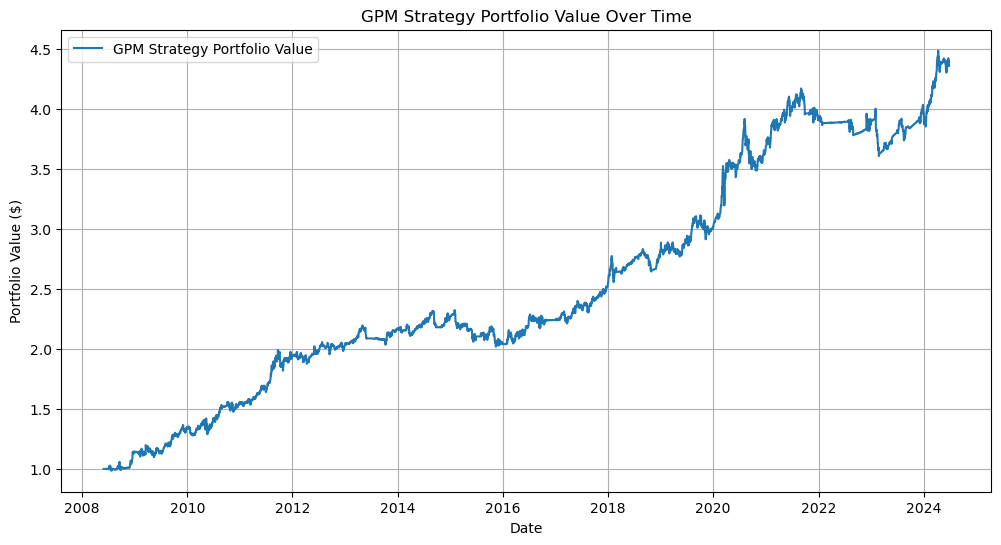

In [231]:
risk_assets = ['SPY', 'QQQ', 'IWM', 'VGK', 'EWJ', 'EEM', 'VNQ', 'DBC', 'GLD', 'HYG', 'LQD', 'TLT', "IEF", "BIL"]
crash_protection_assets = ['IEF', 'BIL']
assets = risk_assets + crash_protection_assets

data = yf.download(assets, start="2007-06-01")['Adj Close']
monthly_prices = data.resample('BM').last()
returns = monthly_prices.pct_change()

# Calculate ri (average of 1, 3, 6, 12-month returns)
ri_1m = returns
ri_3m = returns.rolling(window=3).mean()
ri_6m = returns.rolling(window=6).mean()
ri_12m = returns.rolling(window=12).mean()
ri = (ri_1m + ri_3m + ri_6m + ri_12m) / 4

# Calculate equal-weighted return of the 12 risk assets
equal_weighted_return = returns[risk_assets].mean(axis=1)

# Calculate ci (12-month correlation with the equal-weighted return)
ci = pd.DataFrame(index=ri.index, columns=risk_assets)
for asset in risk_assets:
    ci[asset] = returns[asset].rolling(window=12).corr(equal_weighted_return)
    
# Calculate zi (zi = ri * (1 - ci))
zi = ri[risk_assets] * (1 - ci)
n = (zi[12:] > 0).sum(axis=1)

# Initialize the allocations DataFrame
allocations = pd.DataFrame(index=returns.index, columns=risk_assets + crash_protection_assets).fillna(0)

# Perform monthly rebalancing
for date in zi[12:].index:
    if n.loc[date] <= 6:
        # Allocate 100% to the crash protection asset with the highest zi
        if zi.loc[date, 'IEF'] > zi.loc[date, 'BIL']:
            allocations.loc[date, 'IEF'] = 1.0
        else:
            allocations.loc[date, 'BIL'] = 1.0
    else:
        # Calculate the CP % = (12 - n) / 6
        cp_percent = (12 - n.loc[date]) / 6
        if zi.loc[date, 'IEF'] > zi.loc[date, 'BIL']:
            allocations.loc[date, 'IEF'] = cp_percent
        else:
            allocations.loc[date, 'BIL'] = cp_percent
        
        # Allocate the remaining portfolio to the top 3 risk assets with the highest zi
        top_risk_assets = zi.loc[date].nlargest(3).index
        for asset in top_risk_assets:
            allocations.loc[date, asset] = (1 - cp_percent) / 3

# Forward fill allocations to daily frequency
daily_allocation_df = allocations.reindex(data.index, method='ffill')

# Calculate daily returns of the strategy
strategy_daily_returns = pd.Series(0, index=data.index)
for date, allocation in daily_allocation_df.iterrows():
    daily_returns = sum(data[asset].pct_change().loc[date] * weight for asset, weight in allocation.items() if weight > 0)
    strategy_daily_returns.loc[date] = daily_returns

# Define initial investment
initial_investment = 1

# Calculate the cumulative returns of the strategy
strategy_cumulative_returns = (1 + strategy_daily_returns).cumprod()

# Calculate the portfolio value over time
portfolio_value = strategy_cumulative_returns * initial_investment

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:], label='GPM Strategy Portfolio Value')
plt.title('GPM Strategy Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


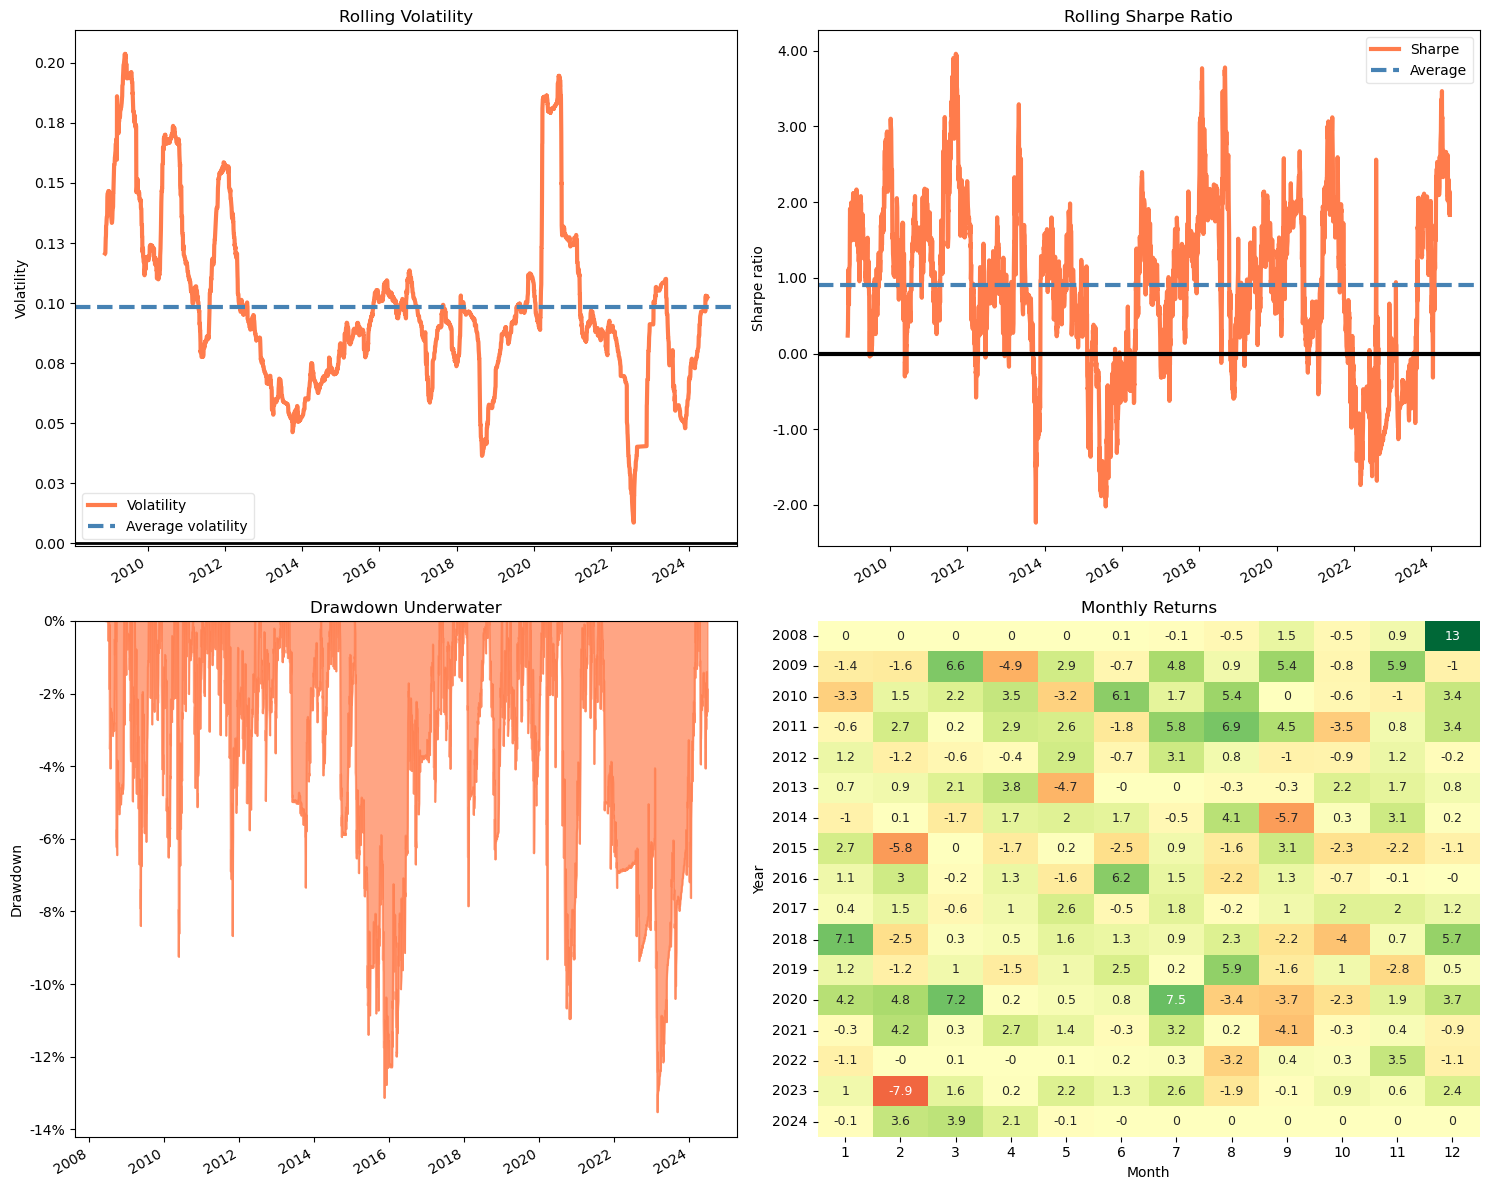

Annual return          0.096258
Cumulative returns     3.370245
Annual volatility      0.105010
Sharpe ratio           0.927785
Calmar ratio           0.711545
Stability              0.937470
Max drawdown          -0.135280
Omega ratio            1.196555
Sortino ratio          1.350902
Skew                   0.180675
Kurtosis               8.631866
Tail ratio             0.959970
Daily value at risk   -0.012843
dtype: float64


In [224]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

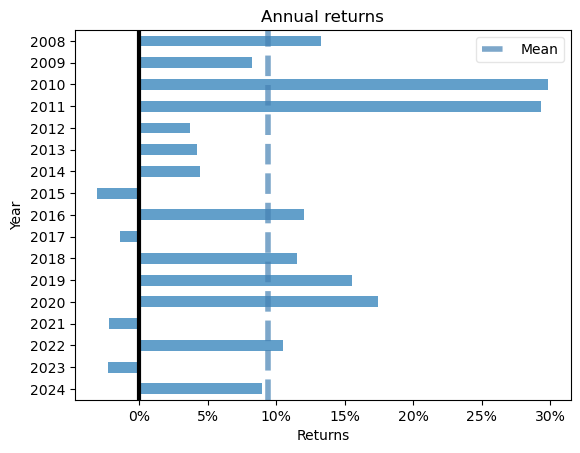

In [232]:
pf.plot_annual_returns(strategy_returns)
